# Antrenam un model de la zero folosind datele colectate

#### Autor: Morariu Tudor

In [31]:
import pandas as pd

data_articulatii = pd.read_csv("date_energie/date_miscare_articulatii/date_interp_articulatii.csv");
data_multiple = pd.read_csv("date_energie/date_multiple/date_interp_07_10_2024.csv");
data_patrat = pd.read_csv("date_energie/date_patrat/date_interp_patrat.csv");
data_triunghi = pd.read_csv("date_energie/date_triunghi/date_interp_triunghi.csv");

In [32]:
def preprocess(data):
    data.dropna(inplace=True);


    # Adaug media pe J(1...6), V(1...6), A(1...6) pentru niste feature engeneering

    data["J_avg"] = (data['J1'] + data['J2'] + data['J3'] + data['J4'] + data['J5'] + data['J6']) / 6; 
    data["V_avg"] = (data['V1'] + data['V2'] + data['V3'] + data['V4'] + data['V5'] + data['V6']) / 6;
    data["A_avg"] = (data['A1'] + data['A2'] + data['A3'] + data['A4'] + data['A5'] + data['A6']) / 6;
    

    # Elimin coloana de timp pentru ca nu ofera date semnificative modelului

    data.drop(columns="Time", inplace=True);
    

    return data;



data_multiple = preprocess(data_multiple);
data_patrat = preprocess(data_patrat);
data_triunghi = preprocess(data_triunghi);


In [33]:
# Concatenez toate datele intr-un DataFrame
# Nu folosesc data_articulatii pentru ca labelul ("Power") are niste valori foarte diferite fata de cele din celelalte 3 seturi de date.
all_data = pd.concat([data_multiple, data_patrat, data_triunghi])

In [34]:
from sklearn.utils import shuffle

# Amestec datele ca sa nu apara ceva patern-uri nedorite 

all_data = shuffle(all_data)

In [35]:
import pandas as pd
import numpy as np

# Plotez o matrice de corelatie
rs = np.random.RandomState(0)
corr = all_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,J1,J2,J3,J4,J5,J6,V1,V2,V3,V4,V5,V6,A1,A2,A3,A4,A5,A6,Power,J_avg,V_avg,A_avg
J1,1.000000,-0.000536,0.029579,0.482825,-0.032635,0.998234,0.004508,0.128580,-0.145571,0.016933,0.007687,0.004657,-0.076405,0.005404,0.000200,0.000170,-0.005824,-0.076183,-0.071600,0.999557,0.004610,-0.076282
J2,-0.000536,1.000000,-0.571213,-0.103196,-0.388430,0.006076,-0.140076,0.003433,-0.100684,0.005930,0.086587,-0.139974,0.006427,-0.076497,0.028108,0.000019,0.048211,0.006407,-0.088379,0.002778,-0.140240,0.006415
J3,0.029579,-0.571213,1.000000,0.113674,-0.534474,0.018397,0.135056,0.087137,0.001135,0.003535,-0.084179,0.135011,-0.000001,0.028048,-0.058062,0.000519,0.035125,0.000017,-0.148066,0.024002,0.135055,0.000030
J4,0.482825,-0.103196,0.113674,1.000000,-0.021357,0.464103,-0.100283,-0.028095,-0.028692,0.025957,0.052540,-0.100215,-0.008446,-0.001327,0.005443,-0.119303,-0.004672,-0.008431,-0.083026,0.473684,-0.100233,-0.008585
J5,-0.032635,-0.388430,-0.534474,-0.021357,1.000000,-0.026891,-0.007429,-0.100996,0.102352,-0.010075,0.005042,-0.007483,-0.006619,0.047292,0.036277,-0.000604,-0.089130,-0.006619,0.257148,-0.029786,-0.007258,-0.006644
J6,0.998234,0.006076,0.018397,0.464103,-0.026891,1.000000,0.004329,0.127968,-0.144922,0.016841,0.007690,0.004477,-0.076101,0.005396,0.000212,0.000148,-0.005829,-0.075882,-0.066402,0.999560,0.004431,-0.075980
V1,0.004508,-0.140076,0.135056,-0.100283,-0.007429,0.004329,1.000000,-0.080851,0.006572,0.020266,0.071330,0.999988,0.058626,0.002227,-0.005558,0.003982,0.003847,0.058872,0.093025,0.004391,0.999990,0.058752
V2,0.128580,0.003433,0.087137,-0.028095,-0.100996,0.127968,-0.080851,1.000000,-0.418174,0.003363,-0.580234,-0.080842,-0.011653,0.062430,-0.041964,0.000835,-0.018689,-0.011674,-0.252154,0.128528,-0.080898,-0.011894
V3,-0.145571,-0.100684,0.001135,-0.028692,0.102352,-0.144922,0.006572,-0.418174,1.000000,-0.017064,-0.497165,0.006351,0.005222,-0.032031,0.070036,-0.002854,-0.044346,0.005202,0.098555,-0.145334,0.006123,0.005111
V4,0.016933,0.005930,0.003535,0.025957,-0.010075,0.016841,0.020266,0.003363,-0.017064,1.000000,0.012162,0.020293,0.005295,-0.000771,-0.009024,0.198093,0.010865,0.005300,-0.008336,0.016895,0.020641,0.005568


In [47]:
all_X = all_data.drop(columns="Power");
all_y = all_data["Power"];

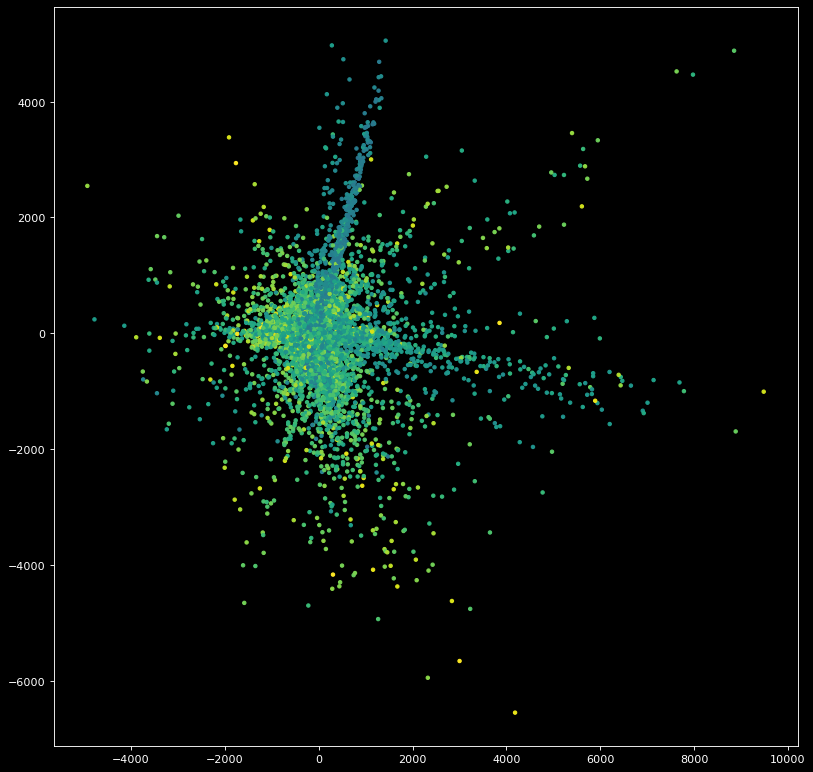

In [54]:
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt

# Fac un plot folosind PCA(algoritm de reducerea dimensiuniilor)
# Setez culoarea la ce valoare trebuie sa prezicem (culoare mai aprinsa daca "power" este mai mare si invers)

plt.style.use("dark_background");

points = PCA(n_components=2).fit_transform(all_X, all_y);

plt.figure(figsize=(12, 12), dpi = 80)
plt.scatter(points[:, 0], points[:, 1], c=all_y, marker='.')

In [37]:
from sklearn.model_selection import train_test_split

# Selectez date de train/test

test_X = all_X[-500:]
test_y = all_y[-500:]

train_X = all_X[:-500]
train_y = all_y[:-500]


In [38]:
import catboost
import xgboost
import lightgbm

# Definesc un model cu hiperparemetrii standard (eventual cu optuna pentru gasirea celor mai buni hiperparametrii)
# Am incercat cu aceeasi hiperparametrii modelele [catboost, xgboost, lightgbm] si xgboost a mers cel mai bine

model = xgboost.XGBRegressor(n_estimators=500, max_depth=8);
model.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [60]:
model.save_model("init_run.model");

/opt/anaconda3/envs/poli_robot_ai/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:45:47] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [39]:
predictii = model.predict(test_X)

In [40]:
from sklearn.metrics import *

print("------ Model Metrics ------\n")
print("R2 Score:", r2_score(test_y, model.predict(test_X)))
print("Mean Squared Error:", mean_squared_error(test_y, model.predict(test_X)))
print("Mean Absolute Error:", mean_absolute_error(test_y, model.predict(test_X)))
print("Root Mean Squared Error:", root_mean_squared_error(test_y, model.predict(test_X)))
print("\n---------------------------")

------ Model Metrics ------

R2 Score: 0.9719226611014118
Mean Squared Error: 2.5899358293747323e-05
Mean Absolute Error: 0.0025676667894104005
Root Mean Squared Error: 0.005089141213775397

---------------------------


[]

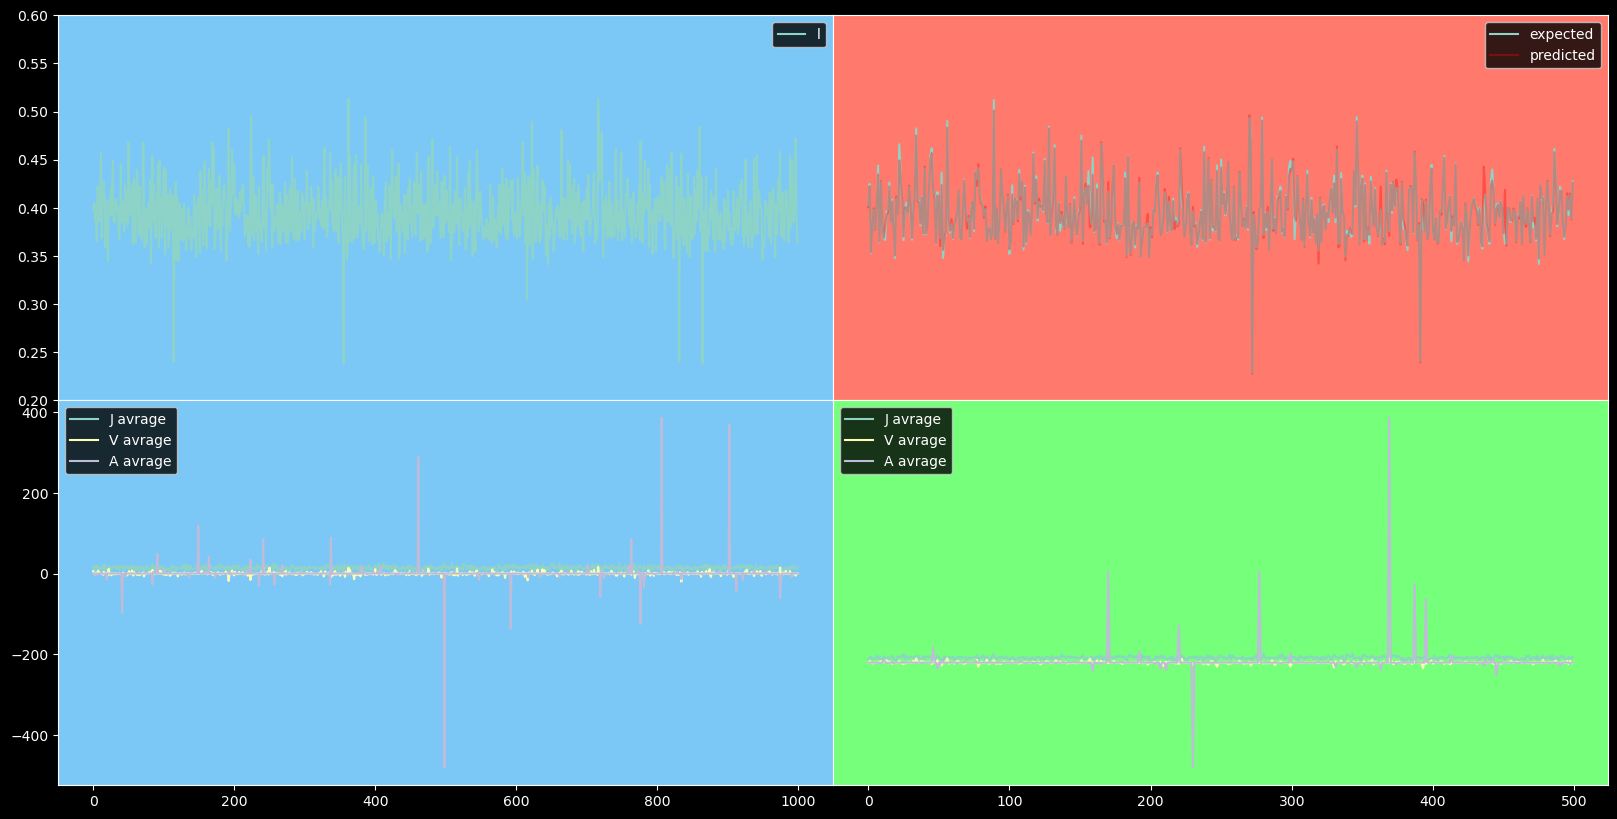

In [59]:
import matplotlib.pyplot as plt

ax = plt.figure(figsize=(20, 10)).subplots(2, 2, gridspec_kw={'width_ratios': [1, 1]})
plt.subplots_adjust(wspace=0, hspace=0)

ax[0][0].set_ylim(ymin=0.2, ymax=0.6)
ax[0][1].set_ylim(ymin=0.2, ymax=0.6)

ax[0][0].set_facecolor('xkcd:lightblue')
ax[1][0].set_facecolor('xkcd:lightblue')
ax[0][1].set_facecolor('xkcd:salmon')
ax[1][1].set_facecolor('xkcd:lightgreen')

ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

set_off_for_train = 1000;


ax[0][0].plot(range(len(train_y[:set_off_for_train])), train_y[:set_off_for_train])
ax[0][0].legend(("labels"))

ax[1][0].plot(range(len(train_X[:set_off_for_train])), train_X[["J_avg", "V_avg", "A_avg"]][:set_off_for_train])
ax[1][0].legend(("J avrage", "V avrage", "A avrage"))


ax[0][1].plot(range(len(test_y)), test_y)
ax[0][1].plot(range(len(test_X)), predictii, c="r", alpha=0.35)
ax[0][1].legend(("expected", "predicted"))

ax[1][1].plot(range(len(test_X)), test_X[["J_avg", "V_avg", "A_avg"]])
ax[1][1].legend(("J avrage", "V avrage", "A avrage"), loc='upper left')
ax[1][1].set_yticks([])